<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-и-предобработка-данных" data-toc-modified-id="Обзор-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор и предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка признаков</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости.
Заказчику важны:
* качество предсказания;
* скорость предсказания;
* время обучения.

## Обзор и предобработка данных

Импортируем необходимые инструменты:

In [1]:
import pandas as pd
import category_encoders as ce
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

### Обзор данных

Загрузим и проанализируем исходные данные:

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except: 
    df = pd.read_csv('autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В данных присутствуют пропуски, типы данных столбцов `DateCrawled`, `NotRepaired`, `DateCreated`, `LastSeen` не соответствуют хранимой в них информации.

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

Данные в столбце `NotRepaired` удобнее заменить на единицу и ноль, где единица означает, что машина ремонтировалась, а ноль, что нет.

In [6]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

В пяти столбцах присутствует большое количество пропусков. Пропуски в `NoRepaired`, вероятно, означают отсутствие ремонта. Пропуски в остальных столбцах указывают только на отсутствие информации, нужно подобрать методы для их заполнения.

In [7]:
df.duplicated().sum()

4

В данных присутствуют дубликаты.

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В столбцах `Price`, `RegistrationYear`, `Power`, `RegistrationMonth` присутствуют аномалии. Столбец `NumberOfPictures` содержит только нулевые значения, практической пользы он не несет.

Проанализируем подробнее распределения столбцов `Price`, `Kilometer`, `RegistrationYear`, `RegistrationMonth`, `Power`:

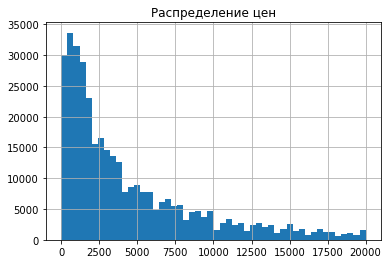

In [11]:
df['Price'].hist(bins=50)
plt.title('Распределение цен');

In [12]:
df['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: Price, Length: 3731, dtype: int64

В целевой переменной присутствуют нулевые значения, однако, они составляют менее 3% от размера датасета. Целевая переменная напрямую влияет на результат, поэтому не будем пытаться заменить нулевые значения на медиану или среднее, а просто удалим содержащие их строки.

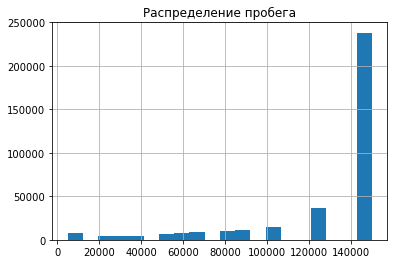

In [14]:
df['Kilometer'].hist(bins=20)
plt.title('Распределение пробега');

Большая часть машин с большим пробегом, что объяснимо: машины редко продают сразу после покупки.

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

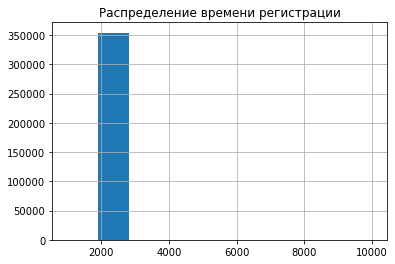

In [17]:
df['RegistrationYear'].hist()
plt.title('Распределение времени регистрации');
df['RegistrationYear'].describe()

В столбце присутствуют аномалии, сузим диапазон значений до реальных:

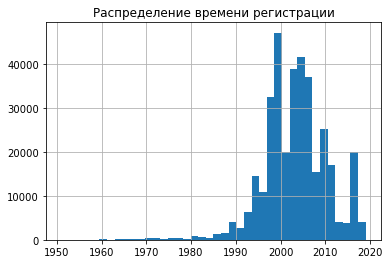

In [22]:
df.query('RegistrationYear < 2023 & RegistrationYear > 1950 ')['RegistrationYear'].hist(bins=40)
plt.title('Распределение времени регистрации');

Узнаем, в каком году была сделана выгрузка данных, чтобы отсечь аномалии:

In [19]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
pd.DatetimeIndex(df['DateCrawled']).year.unique()

Int64Index([2016], dtype='int64', name='DateCrawled')

Чаще всего продают машины, зарегистрированные в период с 1995 до 2010 года. Данные машин с годом регистрации больше 2016 являются аномальными, т.к. выгрузка данных сделана в 2016 г. Найдем нижнюю границу выбросов с помощью диаграммы размаха:

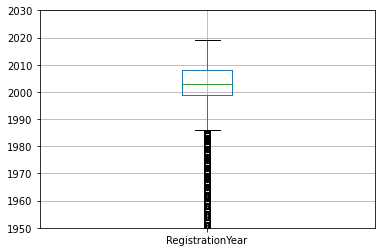

In [23]:
df.boxplot(column='RegistrationYear')
plt.ylim(1950, 2030);

Данные машин с годом регистрации до 1985 являются выбросами, удалим их на этапе предобработки.

Text(0.5, 1.0, 'Распределение времени регистрации по месяцам')

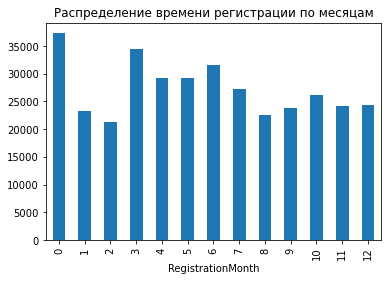

In [24]:
df.groupby('RegistrationMonth')['Kilometer'].count().plot(kind='bar')
plt.title('Распределение времени регистрации по месяцам')

Text(0.5, 1.0, 'Распределение времени регистрации по месяцам')

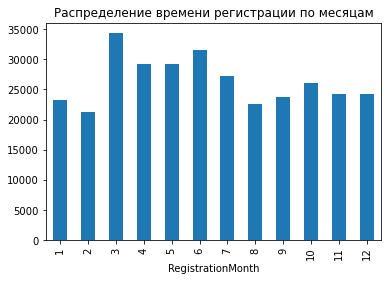

In [26]:
df.query('RegistrationMonth != 0').groupby('RegistrationMonth')['Kilometer'].count().plot(kind='bar')
plt.title('Распределение времени регистрации по месяцам')

Распределение продаж по месяцам близко к равномерному, а потому заполнить нулевые значения какими-то данными, близкими к реальным, не представляется возможным.

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

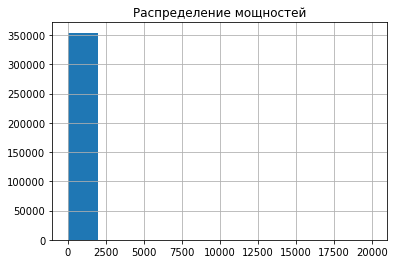

In [29]:
df['Power'].hist()
plt.title('Распределение мощностей')
df['Power'].describe()

В столбце присутствуют аномалии, сузим диапазон значений до реальных:

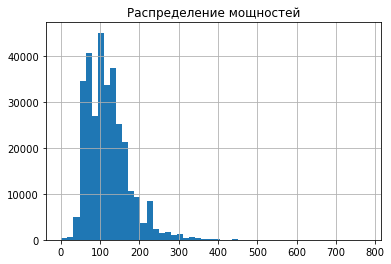

In [31]:
df.query('(Power < 800) & (Power > 0)')['Power'].hist(bins=50)
plt.title('Распределение мощностей');

In [32]:
df['Power'].value_counts()

0       40225
75      24023
60      15897
150     14590
101     13298
        ...  
610         1
6006        1
5815        1
6018        1
1241        1
Name: Power, Length: 712, dtype: int64

Построим диаграмму размаха:

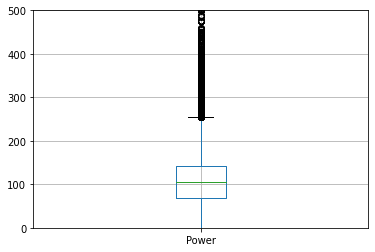

In [34]:
df.boxplot(column='Power')
plt.ylim(0, 500);

В столбце присутствует большое количество нулевых значений, нужно найти метод для их замены. Также, стоит удалить выбросы.

**Вывод**

В ходе анализа исходных данных обнаружены следующие проблемы:
* пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`;
* аномалии в столбцах `Price`, `Power`, `RegistrationYear`;
* ошибочные типы данных в столбцах `DateCrawled`, `DateCreated`, `LastSeen`, `NoRepaired`;
* дубликаты;
* столбцы, не несущие полезной информации.

### Предобработка данных

Удалим дубликаты в данных:

In [35]:
df = df.drop_duplicates().reset_index(drop=True)

Удалим столбцы, которые не пригодятся при построении моделей:
* `DateCrawled`, 
* `RegistrationMonth`, 
* `DateCreated`, 
* `NumberOfPictures`, 
* `LastSeen`.

Индексы столбца `PostalCode`, определяющие регион продажи машины, могут повлиять на цену, т.к. цены в разных регионах возможно отличаются. Несмотря на то, что значения этого столбца численные, индекс - категориальная переменная, которую придется закодировать. Значений у индекса много, какой-либо градации нет, поэтому закодировать его непросто. Проверим, действительно ли индекс влияет на цену и исходя из этого определим удалять столбец или нет.

In [36]:
df = df.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'LastSeen'])

Сложно определить, чем вызваны аномально низкие значения цены: ошибкой при заполнении информации, продажей машины на металлолом или другими причинами. Целевой признак напрямую влияет на точность модели, поэтому, вместо изменения данных на возможно ошибочные значения, просто удалим их:

In [37]:
print('Размер датасета до удаления', df.shape)
df = df.query('Price >= 100')
print('Размер датасета после удаления', df.shape)

Размер датасета до удаления (354365, 11)
Размер датасета после удаления (341051, 11)


Удалим аномалии в столбце `RegistrationYear`:

In [38]:
print('Размер датасета до удаления', df.shape)
df = df.query('(RegistrationYear > 1984) & (RegistrationYear < 2017)')
print('Размер датасета после удаления', df.shape)

Размер датасета до удаления (341051, 11)
Размер датасета после удаления (322509, 11)


Заполним пропуски в столбце `Model` на категорию `other`: 

In [39]:
df.loc[pd.isna(df.Model),'Model'] = 'other'

Заменим аномальные значения в столбце `Power` на медиану значений соответствующей модели, если она указана, а пропуски в столбцах `VehicleType`, `Gearbox`, `FuelType` самыми популярными значениями для конкретной модели:

In [40]:
models = [x for x in df['Model'].unique() if x == x]
for model in models:
    df_model = df.loc[df.Model == model]
    df.loc[(df.Model == model) & ((df.Power < 50) | (df.Power > 400)),'Power'] = df_model['Power'].median()
    df.loc[(df.Model == model) & (pd.isna(df.VehicleType)),'VehicleType'] = df_model.mode()["VehicleType"][0]
    df.loc[(df.Model == model) & (pd.isna(df.Gearbox)),'Gearbox'] = df_model.mode()["Gearbox"][0]
    df.loc[(df.Model == model) & (pd.isna(df.FuelType)),'FuelType'] = df_model.mode()["FuelType"][0]

In [41]:
df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType                0
Brand                   0
NotRepaired         57081
PostalCode              0
dtype: int64

Заменим значения столбца `NotRepaired`, предварительно заполнив пропуски нулями:

In [42]:
df['NotRepaired'] = df['NotRepaired'].fillna(0)
df.loc[df.NotRepaired == 'no', 'NotRepaired'] = 0
df.loc[df.NotRepaired == 'yes', 'NotRepaired'] = 1
df['NotRepaired'] = df['NotRepaired'].astype('int')

In [43]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
PostalCode          0
dtype: int64

Пропуски в данных устранены.

In [44]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,NotRepaired,PostalCode
count,322509.000000,322509.000000,322509.000000,322509.000000,322509.000000,322509.000000
mean,4609.673711,2003.049704,119.469150,128853.194795,0.099145,50795.850116
std,4528.070364,5.824393,50.934772,36771.209937,0.298856,25738.651841
min,100.000000,1985.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1200.000000,1999.000000,78.000000,125000.000000,0.000000,30519.000000
50%,2900.000000,2003.000000,109.000000,150000.000000,0.000000,49632.000000
75%,6600.000000,2007.000000,145.000000,150000.000000,0.000000,71334.000000
max,20000.000000,2016.000000,400.000000,150000.000000,1.000000,99998.000000


В столбце `Power` все еще находятся аномально низкие значения, избавимся от них:

In [45]:
df = df.query('Power >= 50')
df['Power'] = df['Power'].astype('int')

In [46]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,NotRepaired,PostalCode
count,322179.00000,322179.000000,322179.000000,322179.000000,322179.000000,322179.000000
mean,4612.18743,2003.062319,119.562187,128917.108191,0.099119,50812.366911
std,4529.15029,5.809851,50.876847,36707.900238,0.298822,25729.240173
min,100.00000,1985.000000,50.000000,5000.000000,0.000000,1067.000000
25%,1200.00000,1999.000000,79.000000,125000.000000,0.000000,30519.000000
50%,2900.00000,2003.000000,109.000000,150000.000000,0.000000,49661.000000
75%,6600.00000,2007.000000,145.000000,150000.000000,0.000000,71334.000000
max,20000.00000,2016.000000,400.000000,150000.000000,1.000000,99998.000000


Проверим корреляцию признаков:

In [47]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,NotRepaired,PostalCode
Price,1.000000,0.568071,0.513307,-0.369280,-0.187391,0.070992
RegistrationYear,0.568071,1.000000,0.123508,-0.356265,-0.099227,0.034802
Power,0.513307,0.123508,1.000000,0.095764,-0.045220,0.057008
Kilometer,-0.369280,-0.356265,0.095764,1.000000,0.072653,-0.012283
NotRepaired,-0.187391,-0.099227,-0.045220,0.072653,1.000000,-0.000232
PostalCode,0.070992,0.034802,0.057008,-0.012283,-0.000232,1.000000


На цену заметно влияют год регистрации, мощность и пробег. Проанализируем подробнее зависимость цены от индекса местонахождения продавца:

<AxesSubplot:xlabel='Price', ylabel='PostalCode'>

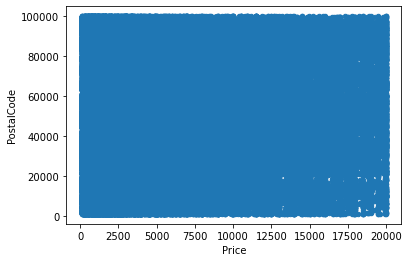

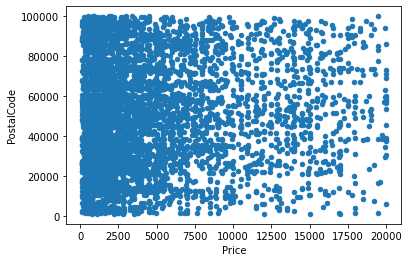

In [48]:
df.plot.scatter(x='Price', y='PostalCode')
df.head(5000).plot.scatter(x='Price', y='PostalCode')

Цена не зависит от индекса: в каждом сегменте цены примерно равное количество машин из разных регионов. Столбец `PostalCode` можно удалить:

In [49]:
df = df.drop(columns=['PostalCode'])

На этапе предобработки данных:
* заполнены пропуски в столбцах `VehicleType`, `Gearbox`, `FuelType`, `NotRepaired`;
* устранены аномалии в столбцах `Price`, `Power`, `RegistrationYear`;
* удалены дубликаты;
* удалены бесполезные для построения модели столбцы `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `LastSeen`, `PostalCode`.

### Подготовка признаков

Определим признаки и целевой признак:

In [50]:
features = df.drop(['Price'], axis=1)
target = df['Price']
features.shape, target.shape

((322179, 9), (322179,))

Закодируем данные столбцов `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand` с помощью `CatBoostEncoder`. Выберем именно его, т.к. он не способствует разрастанию датафрейма и не устанавливает какой-либо градации между категориальными переменными. Это позволит использовать данные для моделей случайного леса и логистической регрессии:

In [51]:
cbe_encoder = ce.cat_boost.CatBoostEncoder()
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']
cbe_encoder.fit(features, target, cols=categorical)
features_cbe = cbe_encoder.transform(features)
features_cbe.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,4561.153101,1993,4036.181395,101,4371.515550,150000,3701.896301,4597.171668,0
1,6104.422952,2011,4036.181395,190,3881.109060,125000,6664.117161,6541.840008,1
2,9160.500571,2004,6972.870590,163,6488.106376,125000,6664.117161,7273.316730,0
3,2676.722722,2001,4036.181395,75,4371.515550,150000,3701.896301,4597.171668,0
4,2676.722722,2008,4036.181395,69,4244.602676,90000,6664.117161,6042.615756,0


Разделим данные на тренировочную и тестовую части:

In [52]:
features_train, features_test, target_train, target_test = train_test_split(
    features_cbe, target, random_state=1703, test_size=0.25)
features_train.shape, features_test.shape

((241634, 9), (80545, 9))

Масштабируем признаки тренировочной выборки, чтобы уравнять вклад переменных, значения которых различаются на несколько порядков:

In [53]:
scaler = StandardScaler()
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler.fit(features_train[numeric])

features_train_scaled = features_train.copy()
features_test_scaled = features_test.copy()
features_train_scaled[numeric] = scaler.transform(features_train_scaled[numeric])
features_test_scaled[numeric] = scaler.transform(features_test_scaled[numeric])

**Вывод**

На этапе подготовки признаков данные:
* разделены на признаки и целевой признак;
* закодированы с помощью `CatBoostEncoder`;
* разделены на обучающую и тестовую части;
* отмасштабированы.

## Обучение моделей

Обучим модели случайного леса, линейной регрессии и два варианта градиентного бустинга. Сравним их время обучения, предсказания и значение метрики RMSE.

Функция, определяющая RMSE:

In [54]:
def rmse(target, predicted):
    return mse(target, predicted) ** 0.5

Функции, определяющие время обучения и предсказания:

In [55]:
def learning_time(model, features, target):
    start = time.time()
    model.fit(features, target)
    end = time.time()
    time_fit = end - start
    return time_fit, model

def predicting_time(model, features):
    start = time.time()
    predict = model.predict(features)
    end = time.time()
    time_predict= end - start
    return time_predict, predict

Найдем лучшие параметры для случайного леса с помощью `GridSearch`:

In [56]:
%%time
model_rfr = RandomForestRegressor(random_state=1703)
parameters = { 'n_estimators': [50, 100, 150], 'max_depth': [2, 6, 10]}
grid_rfr = GridSearchCV(model_rfr, parameters, cv=5, scoring='neg_root_mean_squared_error')
grid_rfr.fit(features_train_scaled, target_train)
grid_rfr.best_params_, grid_rfr.best_score_

Wall time: 13min 34s


({'max_depth': 10, 'n_estimators': 150}, -1772.3538116119532)

Обучим модель случайного леса с найденными гиперпараметрами:

In [57]:
learn_time_rfr, model_rfr = learning_time(RandomForestRegressor(max_depth=10, n_estimators=150, random_state=1703), 
                                       features_train_scaled, target_train)
pred_time_rfr, pred_rfr = predicting_time(model_rfr, features_test_scaled)
rmse_rfr = rmse(target_test, pred_rfr)
params = []
params.append([rmse_rfr, learn_time_rfr, pred_time_rfr])

Проанализируем важность признаков для итоговой модели:

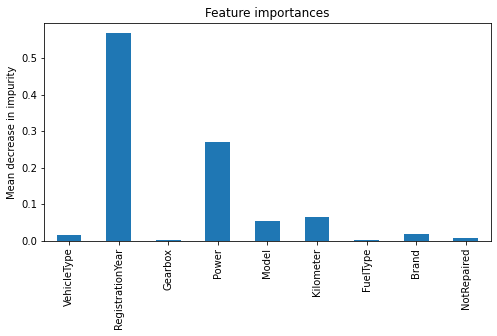

In [58]:
model_importances = pd.Series(model_rfr.feature_importances_, index=features.columns)
model_importances.plot.bar(figsize=(8,4))
plt.title("Feature importances")
plt.ylabel("Mean decrease in impurity");

Наиболее важные факторы по мнению `RandomForestRegressor` это год регистрации и мощность. Модель и пробег делят 3 место, их значимость алгоритм оценивает намного ниже. Остальные факторы практически не влияют на результаты предсказаний.

Закодируем признаки для линейной регресии с помощью `OneHotEncoding`, разделим данные на тренировочные и тестовые и отмасштабируем их:

In [59]:
features_ohe = pd.get_dummies(features, columns=
                              ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand'], drop_first=True)

features_train, features_test, target_train, target_test = train_test_split(
    features_ohe, target, random_state=1703, test_size=0.25)

scaler.fit(features_train[numeric])

features_train_scaled = features_train.copy()
features_test_scaled = features_test.copy()
features_train_scaled[numeric] = scaler.transform(features_train_scaled[numeric])
features_test_scaled[numeric] = scaler.transform(features_test_scaled[numeric])

Обучим модель линейной регресии:

In [60]:
learn_time_lr, model_lr = learning_time(LinearRegression(), features_train_scaled, target_train)
pred_time_lr, pred_lr = predicting_time(model_lr, features_test_scaled)
rmse_lr = rmse(target_test, pred_lr)
params.append([rmse_lr, learn_time_lr, pred_time_lr])

Для моделей бустинга будем использовать данные с незакодированными категориальными переменными:

In [61]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=1703, test_size=0.25)
features_train.shape, features_test.shape

((241634, 9), (80545, 9))

Найдем лучшие гиперпараметры для `CatBoostRegressor`:

In [62]:
%%time
model_cbr = CatBoostRegressor(loss_function='RMSE', verbose=False, random_state=1703, cat_features=categorical)
parameters = {'depth' : [7, 10], 'learning_rate': [0.05, 0.1, 0.2]}
grid_cbr = model_cbr.grid_search(parameters, features_train, target_train, cv=3)
grid_cbr["params"]


bestTest = 1582.08686
bestIteration = 999

0:	loss: 1582.0868599	best: 1582.0868599 (0)	total: 1m 40s	remaining: 8m 24s

bestTest = 1555.977475
bestIteration = 999

1:	loss: 1555.9774748	best: 1555.9774748 (1)	total: 3m 27s	remaining: 6m 54s

bestTest = 1537.810394
bestIteration = 995

2:	loss: 1537.8103940	best: 1537.8103940 (2)	total: 5m 27s	remaining: 5m 27s

bestTest = 1533.679236
bestIteration = 999

3:	loss: 1533.6792358	best: 1533.6792358 (3)	total: 8m 49s	remaining: 4m 24s

bestTest = 1515.416504
bestIteration = 999

4:	loss: 1515.4165040	best: 1515.4165040 (4)	total: 12m 16s	remaining: 2m 27s

bestTest = 1510.086405
bestIteration = 985

5:	loss: 1510.0864045	best: 1510.0864045 (5)	total: 15m 41s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 1523.427483
bestIteration = 999

Training on fold [1/3]

bestTest = 1506.585971
bestIteration = 987

Training on fold [2/3]

bestTest = 1524.538718
bestIteration = 999

Wall time: 28min 36s


{'depth': 10, 'learning_rate': 0.2}

Обучим модель `CatBoostRegressor` с найденными гиперпараметрами:

In [63]:
learn_time_cbr, model_cbr = learning_time(CatBoostRegressor(loss_function="RMSE", 
                                                            depth=10, learning_rate=0.2, random_state=1703, 
                                                            cat_features=categorical, verbose=200), features_train, target_train)
pred_time_cbr, pred_cbr = predicting_time(model_cbr, features_test)
rmse_cbr = rmse(target_test, pred_cbr)
params.append([rmse_cbr, learn_time_cbr, pred_time_cbr])

0:	learn: 4185.7836713	total: 181ms	remaining: 3m
200:	learn: 1493.8028331	total: 37.1s	remaining: 2m 27s
400:	learn: 1426.9959094	total: 1m 14s	remaining: 1m 51s
600:	learn: 1384.0471574	total: 1m 55s	remaining: 1m 16s
800:	learn: 1351.3624837	total: 2m 38s	remaining: 39.5s
999:	learn: 1327.8675468	total: 3m 24s	remaining: 0us


Выявим признаки, внесшие наибольший вклад:

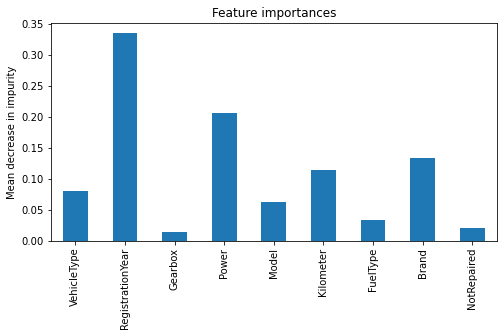

In [66]:
model_importances = pd.Series(model_cbr.feature_importances_/100, index=features.columns)
model_importances.plot.bar(figsize=(8,4))
plt.title("Feature importances")
plt.ylabel("Mean decrease in impurity");

Важные факторы у `CatBoostRegressor` совпали с важными факторами `RandomForestRegressor`: год регистрации, мощность. Однако, `CatBoostRegressor` выделяет также бренд, пробег, модель и тип коробки передач. В целом, влияние признаков распределено равномернее, чем у `RandomForestRegressor`.

Найдем лучшие параметры для `LightGBM`, предварительно изменив тип данных категориальных столбцов на `object`:

In [67]:
for column in categorical:
    features_train[column] = features_train[column].astype('category')
    features_test[column] = features_test[column].astype('category')

In [72]:
%%time
model_lgbm = LGBMRegressor(boosting_type='gbdt', seed=1703)
parameters = {'learning_rate': [0.05, 0.1], 'num_leaves': range(200, 601, 200), 'n_estimators': [200, 400, 800]}
grid_lgbm = GridSearchCV(model_lgbm, parameters, cv=3, scoring='neg_root_mean_squared_error')
grid_lgbm.fit(features_train, target_train)
grid_lgbm.best_params_, grid_lgbm.best_score_

Wall time: 9min 27s


({'learning_rate': 0.05, 'n_estimators': 800, 'num_leaves': 200},
 -1499.1237010840177)

Обучим `LightGBM` с найденными гиперпараметрами:

In [73]:
learn_time_lgbm, model_lgbm = learning_time(LGBMRegressor(boosting_type='gbdt', 
                                                          seed=1703, learning_rate=0.05, num_leaves=200, 
                                                          n_estimators=800), features_train, target_train)
pred_time_lgbm, pred_lgbm = predicting_time(model_lgbm, features_test)
rmse_lgbm = rmse(target_test, pred_lgbm)
params.append([rmse_lgbm, learn_time_lgbm, pred_time_lgbm])

Проверим, какой признак внес наибольший вклад:

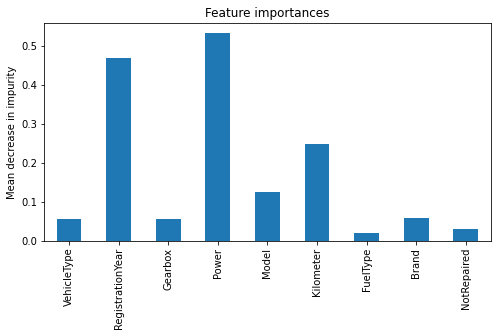

In [74]:
model_importances = pd.Series((model_lgbm.feature_importances_)/100000, index=features.columns)
model_importances.plot.bar(figsize=(8,4))
plt.title("Feature importances")
plt.ylabel("Mean decrease in impurity");

Наибольший вклад на итоговый результат для модели `LGBM` оказали мощность и год регистрации, что схоже с другими моделями, однако, это первая модель, где больший вклад остался за мощностью. В целом, распредление влияния признаков схоже с распределением `CatBoostEncoder`.

Сформируем итоговую таблицу результатов:

In [75]:
final_df = pd.DataFrame(list(zip(params[0], params[1], params[2], params[3])), index=['RMSE', 'learning_time', 'predicting_time'],
                        columns=['RandomForestRegressor', 'LinearRegressor', 'CatBoostRegressor', 'LGBM'])
final_df

,RandomForestRegressor,LinearRegressor,CatBoostRegressor,LGBM
RMSE,1790.604507,6.058998e+12,1526.647076,1492.249707
learning_time,52.380280,3.550161e+00,205.561146,8.599733
predicting_time,1.099861,9.824467e-02,0.612643,2.087924


**Вывод**

На этапе обучения моделей:
* подобраны лучшие гиперпараметры для каждого варианта моделей;
* найдено время обучения и предсказания;
* рассчитана метрика RMSE;
* сформирована таблица результатов.

## Итоговый вывод

Лучшие результаты по важным для заказчика критериям показали:
* лучшее время обучения - `LinearRegressor`;
* лучшее время предсказания - `LinearRegressor`;
* лучший результат RMSE - `LGBM`.

По совокупности всех факторов лучшей моделью признаем `LightGBM`: лучший показатель RMSE, по времени обучения уступает только модели линейной регрессии, намного быстрее остальных моделей, имеет самое большое время предсказания, но оно все еще не слишком велико.

Если время предсказания для заказчика намного важнее времени обучения, то лучше выбрать `CatBoostRegressor`: хороший показатель RMSE, сравнимый с `LightGBM`, по времени предсказания уступает только модели линейной регрессии.